Imports etc

In [1]:
%load_ext autoreload
%autoreload 2
%autosave 60

from multiprocessing import Pool

import strawberryfields as sf
from qutip import wigner

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm, colors, colorbar, colormaps
import matplotlib.ticker as tkr

mpl.rcParams["mathtext.fontset"] = "cm"
mpl.rcParams["font.family"] = "STIXGeneral"
mpl.rcParams["lines.linewidth"] = 2
plt.rcParams.update({"font.size": 18})

π = np.pi
vacuum_FWHM = 2 * np.sqrt(2 * np.log(2)) * np.sqrt(0.5)

import sys, os

# include parent directory in import path
sys.path.insert(1, os.path.join(os.getcwd(), "../python_source"))
sys.path.insert(1, os.path.join(os.getcwd(), "../scripts"))

from operators import *
from states import *
from loss_channels import *
from encoding_channels import *
from fisher_information import *
from plotters import *
from variational_algorithm import *
from QFIM_SMSV import *

import scipy
import pandas as pd
from tqdm.notebook import tqdm
from glob import glob
from pathlib import Path

Autosaving every 60 seconds


In [2]:
def smsv_r_from_variance(variance0):
    """Var[x] = e^-2r / 2, Var[p] = e^2r / 2"""
    return -np.log(2 * variance0) / 2  # = r


def smsv_r_from_stdev(stdev0):
    return smsv_r_from_variance(stdev0**2)


def lossy_UB_Tuvia(σ, η_input, nbar):
    """UB on the ECQFI at nbar"""
    fraction_Tuvia = lambda xSqr: xSqr / ((1 - η_input) + 2 * η_input * xSqr)
    lossy_UB_Tuvia_xSqr = (
        lambda xSqr: 4 * fraction_Tuvia(xSqr) / (1 + 2 * fraction_Tuvia(xSqr) * σ**2)
    )

    # converting xSqr (really, here, pSqr) to nBar in the same way as SMSV
    xSqr_SMSV = nbar + 0.5 + np.sqrt(nbar * (1 + nbar))
    return lossy_UB_Tuvia_xSqr(xSqr_SMSV)


def marginals(W, xvec, pvec):
    margs = dict()

    # integral along p
    Δx = xvec[1] - xvec[0]
    margs["x"] = np.sum(Δx * W, axis=0)

    # integral along x
    Δp = pvec[1] - pvec[0]
    margs["p"] = np.sum(Δp * W, axis=0)

    # norm
    margs["norm"] = np.sum(Δp * margs["x"])

    return margs

In [3]:
# Bang Wong color blind--friendly colours
COLOURS = {
    "Black": "#000000",
    "Orange": "#E69F00",
    "Sky blue": "#56B4E9",
    "Bluish green": "#009E73",
    "Yellow": "#F0E442",
    "Blue": "#0072B2",
    "Vermillion": "#D55E00",
    "Reddish purple": "#CC79A7",
}


def grid(ax):
    ax.grid("both", "both", color="gainsboro", zorder=0)


def legend(ax, reversed=False, **kwargs):
    defaults = dict(handlelength=1, labelspacing=0, frameon=False, handletextpad=0.3)
    if reversed:
        h, l = ax.get_legend_handles_labels()
        ax.legend(handles=reversed(h), labels=reversed(l), **(defaults | kwargs))
    else:
        ax.legend(**(defaults | kwargs))


def colorbar_without_resizing(fig, ax, image, pad=0.05, fmt=None):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=pad)
    # TODO: fix formatter to handle overall order scaling
    # e.g. fmt = '%.1g'
    if fmt is not None:
        fig.colorbar(image, cax=cax, format=tkr.FormatStrFormatter(fmt))
    else:
        fig.colorbar(image, cax=cax)


def plot_options(
    key,
    # n_input=None,
    **kwargs,
):
    defaults = {
        "vacuum": dict(color=COLOURS["Orange"], label=r"vacuum QFI (CFI $\hat n$)"),
        "vacuum quadrature CFI": dict(
            # color=COLOURS["Yellow"],
            color=COLOURS["Reddish purple"],
            linestyle="--",
            label=r"vacuum CFI $\hat p$",
        ),
        # to match vacuum
        "coherent": dict(
            color=COLOURS["Orange"],
            linestyle="-",
            label="Coherent",
        ),
        "SMSV": dict(
            color=COLOURS["Bluish green"],
            linestyle="-.",
            label="SMSV",
        ),
        "Fock": dict(
            color=COLOURS["Vermillion"],
            linestyle=":",
            label="Fock",
        ),
        "TMSV": dict(
            color=COLOURS["Sky blue"],
            linestyle="--",
            label="TMSV",
        ),
        "TMSV-PS": dict(
            color=COLOURS["Reddish purple"],
            linestyle=":",
            label="TMSV-PS",
        ),
        "cat": dict(
            color=COLOURS["Reddish purple"],
            linestyle=":",
            label="Cat",
        ),
        "channel": dict(
            color=COLOURS["Blue"],
            linestyle="-",
            label="Channel QFI",
            # linewidth=0.8,
        ),
    }
    # if key in ["SMSV QFI", "Fock QFI"] and n_input is None:
    #     raise ValueError("n_input not provided.")
    options = defaults[key]
    # union (|) returns a dict with the union of keys, preferencing the second slot in the case of key conflicts
    return options | kwargs

Parallelisation

In [10]:
from multiprocessing import Pool

def process_item(item):
    # Perform some computation on the item
    return item * 2

items = list(range(int(1e5)))
result_list = []

with Pool() as pool:
    pbar = tqdm(total=len(items))
    for result in pool.imap(process_item, items):
        result_list.append(result)
        pbar.update(1)
    pbar.close()

print(result_list)

  0%|          | 0/100000 [00:00<?, ?it/s]

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 398, 400, 402, 404, 406, 408, 410, 412, 414, 416, 418, 420,

In [11]:
def process_item(item):
    # Perform some computation on the item
    return item * 2

items = list(range(int(1e5)))
result_list = []

with Pool() as pool:
    pbar = tqdm(total=len(items))
    for result in map(process_item, items):
        result_list.append(result)
        pbar.update(1)
    pbar.close()

print(result_list)

  0%|          | 0/100000 [00:00<?, ?it/s]

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 360, 362, 364, 366, 368, 370, 372, 374, 376, 378, 380, 382, 384, 386, 388, 390, 392, 394, 396, 398, 400, 402, 404, 406, 408, 410, 412, 414, 416, 418, 420,

Test

In [4]:
N = 1000
grid_nmax = 10
num_peaks = 2 * grid_nmax + 1
print(num_peaks, "peaks")

21 peaks


<StemContainer object of 3 artists>

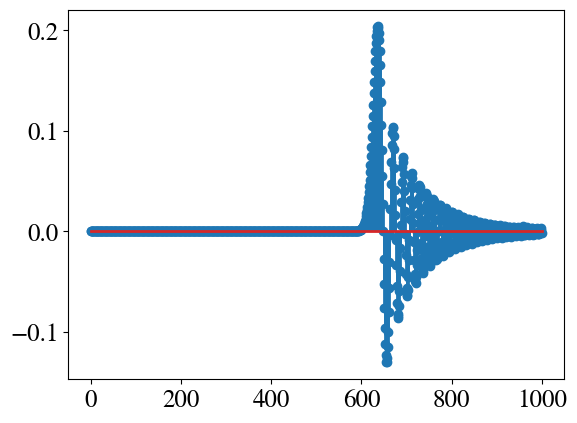

In [5]:
Δ = 0.1
r = smsv_r_from_stdev(Δ / np.sqrt(2))

vacuum = fock_ket(N, 0)
sqz_state = squeeze(N, vacuum, r=r, θ=0)

x = 2 * 10 * np.sqrt(π)

plt.stem(X_gate(N, sqz_state, q=x).real)

In [6]:
N = 1000
grid_nmax = 10
num_peaks = 2 * grid_nmax + 1
vacuum = fock_ket(N, 0)

def process_that_data(Δ):
    r = smsv_r_from_stdev(Δ / np.sqrt(2))
    sqz_state = squeeze(N, vacuum, r=r, θ=0)

    ket = np.zeros(N, dtype=complex)

    # Change to +1 on the RHS to include the last peak thanks to Jeff Wack
    for n in range(-grid_nmax, grid_nmax + 1):
        # Gottesman+, Tzitrin+ window rather than Zhuang+
        x = 2 * n * np.sqrt(π)
        window = np.exp(-0.5 * Δ**2 * x**2)
        ket += window * X_gate(N, sqz_state, q=x)

    ket = normalise(N, ket)
    nbar0 = average_number(N, ket)
    var_x = variance(N, ket, x_quad(N))
    var_p = variance(N, ket, p_quad(N))
    window_max = np.exp(-0.5 * Δ**2 * (2 * grid_nmax * np.sqrt(π)) ** 2)
    # print('state created')

    # lossless results
    settings = dict(
        N=N,
        σ=1e-3,
        δσ=1e-8,
        η=0,
        small_signal=True,
        loss_tol=1e-100,
    )
    construct_total_channel(settings)
    Fq_lossless = QFI_finite_difference(ket, settings)

    TMSV0_lossless = QFIM_TMSV(
        σ=settings["σ"], n=nbar0, η=1e-50, ηa=0, loss_type="input"
    )
    # print('lossless QFI calculated')

    # lossy results
    settings = dict(
        N=N,
        σ=1e-3,
        δσ=1e-8,
        η=1e-1,
        small_signal=True,
        loss_tol=1e-100,
    )
    construct_total_channel(settings)
    Fq = QFI_finite_difference(ket, settings)

    TMSV0 = QFIM_TMSV(
        σ=settings["σ"], n=nbar0, η=settings["η"], ηa=0, loss_type="input"
    )
    UB0 = lossy_UB_Tuvia(σ=settings["σ"], η_input=settings["η"], nbar=nbar0)
    # print('lossy QFI calculated')

    return dict(
            QFI=Fq,
            nbar=nbar0,
            Δ=Δ,
            r=r,
            window_max=window_max,
            var_x=var_x,
            var_p=var_p,
            ratio_var_x_to_var_p=var_x / var_p,
            ratio_var_x_to_nbar=var_x / nbar0,
            ratio_ECQFI_UB=Fq / UB0,
            ECQFI_UB=UB0,
            ratio_TMSV=Fq / TMSV0,
            TMSV=TMSV0,
            QFI_lossless=Fq_lossless,
            ratio_TMSV_lossless=Fq_lossless / TMSV0_lossless,
            TMSV_lossless=TMSV0_lossless,
        )

In [ ]:
%%time

num_points = 100  # for plotting
# num_points = 10 # for testing
# num_points = 2 # for desparate testing

# Delta=0.1 is nbar=50, Delta=1 is nbar=0.
Δs = np.geomspace(0.1, 1, num_points)

data = []

with Pool(processes=16) as pool:
    pbar = tqdm(total=num_points)
    for results in pool.imap(process_that_data, Δs):
        data.append(results)
        pbar.update(1)
    pbar.close()

data = pd.DataFrame(data)

  0%|          | 0/100 [00:00<?, ?it/s]

/central/home/jwgardne/pleasantpheasant/loss_channels.py:95: RuntimeWarning: divide by zero encountered in log
/central/home/jwgardne/pleasantpheasant/loss_channels.py:95: RuntimeWarning: divide by zero encountered in log
/central/home/jwgardne/pleasantpheasant/loss_channels.py:95: RuntimeWarning: divide by zero encountered in log
/central/home/jwgardne/pleasantpheasant/loss_channels.py:95: RuntimeWarning: divide by zero encountered in log
/central/home/jwgardne/pleasantpheasant/loss_channels.py:95: RuntimeWarning: divide by zero encountered in log
/central/home/jwgardne/pleasantpheasant/loss_channels.py:95: RuntimeWarning: divide by zero encountered in log
/central/home/jwgardne/pleasantpheasant/loss_channels.py:95: RuntimeWarning: divide by zero encountered in log
/central/home/jwgardne/pleasantpheasant/loss_channels.py:95: RuntimeWarning: divide by zero encountered in log
/central/home/jwgardne/pleasantpheasant/loss_channels.py:95: RuntimeWarning: divide by zero encountered in log
/

In [9]:
file_tag = f"{num_peaks}_peaks_{N}_dim_{num_points}_points_Fixest_actually_parallel"
# file = f"../data/GKP/QFI_vs_nbar---DeltaSqrt2_{file_tag}.txt"
file = f"QFI_vs_nbar---DeltaSqrt2_{file_tag}.txt"
data.to_csv(file, index=False)

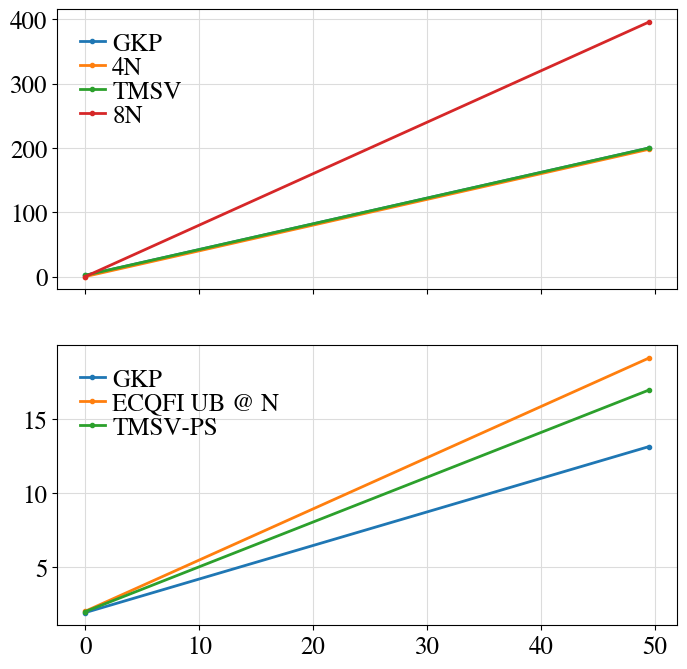

In [10]:
fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

ax = axs[0]
ax.plot(data["nbar"], data["QFI_lossless"], ".-", label="GKP")
ax.plot(data["nbar"], 4 * data["nbar"], ".-", label="4N")
ax.plot(data["nbar"], data["TMSV_lossless"], ".-", label="TMSV")
ax.plot(data["nbar"], 8 * data["nbar"], ".-", label="8N")

ax = axs[1]
ax.plot(data["nbar"], data["QFI"], ".-", label="GKP")
ax.plot(data["nbar"], data["ECQFI_UB"], ".-", label="ECQFI UB @ N")
ax.plot(data["nbar"], data["TMSV"], ".-", label="TMSV-PS")

for ax in axs:
    grid(ax)
    legend(ax)

plt.show()